<a href="https://colab.research.google.com/github/lucifi65/carwash-admin/blob/main/%D0%94%D0%98%D0%90%D0%9E%D0%9D%D0%A1%D0%A2_%D0%94%D0%9B%D0%AF_%D0%94%D0%98%D0%9F%D0%9B%D0%9E%D0%9C%D0%90.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install torch torchvision torchaudio matplotlib numpy pandas pillow scikit-learn gradio



NameError: name 'model' is not defined

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import torch

In [4]:
data_dir = "/content/drive/MyDrive/Colab Notebooks/gaussian_filtered_images/gaussian_filtered_images"


In [5]:
# Трансформации изображений
data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Загрузка данных с автоматической маркировкой по подпапкам
full_dataset = datasets.ImageFolder(root=data_dir, transform=data_transforms)

# Проверка классов
print("Классы:", full_dataset.classes)

# Разделение на обучающий и тестовый наборы
train_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_size
train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

print(f"Обучающих изображений: {train_size}, Тестовых изображений: {test_size}")

Классы: ['Mild', 'Moderate', 'No_DR', 'Proliferate_DR', 'Severe']
Обучающих изображений: 2929, Тестовых изображений: 733


In [6]:
import torch.nn as nn
import torch.optim as optim
import torch

# Улучшенная модель с BatchNorm и Dropout
class FundusDiagnosisCNN(nn.Module):
    def __init__(self, num_classes=5):
        super(FundusDiagnosisCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding=1), nn.BatchNorm2d(64), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 3, padding=1), nn.BatchNorm2d(128), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(128, 256, 3, padding=1), nn.BatchNorm2d(256), nn.ReLU(), nn.AdaptiveAvgPool2d((7,7))
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256*7*7, 512), nn.ReLU(), nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        return self.classifier(x)

# Инициализация модели и перемещение на устройство
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = FundusDiagnosisCNN().to(device)

# Определение критерия и оптимизатора
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Функция обучения
def train_model(model, criterion, optimizer, train_loader, test_loader, epochs=25):
    train_losses, test_losses = [], []

    for epoch in range(epochs):
        model.train()
        total_train_loss = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_train_loss += loss.item()

        avg_train_loss = total_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        model.eval()
        total_test_loss = 0
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                total_test_loss += loss.item()

        avg_test_loss = total_test_loss / len(test_loader)
        test_losses.append(avg_test_loss)

        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss:.4f}, Test Loss: {avg_test_loss:.4f}")

    return train_losses, test_losses

# Запуск обучения
train_losses, test_losses = train_model(model, criterion, optimizer, train_loader, test_loader, epochs=50)


Epoch 1/50, Train Loss: 0.9116, Test Loss: 0.8020
Epoch 2/50, Train Loss: 0.8261, Test Loss: 0.7741
Epoch 3/50, Train Loss: 0.7659, Test Loss: 0.7291
Epoch 4/50, Train Loss: 0.7508, Test Loss: 0.7332
Epoch 5/50, Train Loss: 0.7317, Test Loss: 0.9203
Epoch 6/50, Train Loss: 0.7188, Test Loss: 0.7006
Epoch 7/50, Train Loss: 0.7077, Test Loss: 0.6704
Epoch 8/50, Train Loss: 0.6909, Test Loss: 1.1330
Epoch 9/50, Train Loss: 0.6798, Test Loss: 0.6660
Epoch 10/50, Train Loss: 0.6705, Test Loss: 0.6488
Epoch 11/50, Train Loss: 0.6687, Test Loss: 0.6599
Epoch 12/50, Train Loss: 0.6492, Test Loss: 0.6526
Epoch 13/50, Train Loss: 0.6515, Test Loss: 0.6590
Epoch 14/50, Train Loss: 0.6417, Test Loss: 0.6225
Epoch 15/50, Train Loss: 0.6457, Test Loss: 0.7125
Epoch 16/50, Train Loss: 0.6463, Test Loss: 0.9826
Epoch 17/50, Train Loss: 0.6230, Test Loss: 0.8421
Epoch 18/50, Train Loss: 0.6262, Test Loss: 0.6194
Epoch 19/50, Train Loss: 0.6133, Test Loss: 0.7044
Epoch 20/50, Train Loss: 0.6328, Test Lo

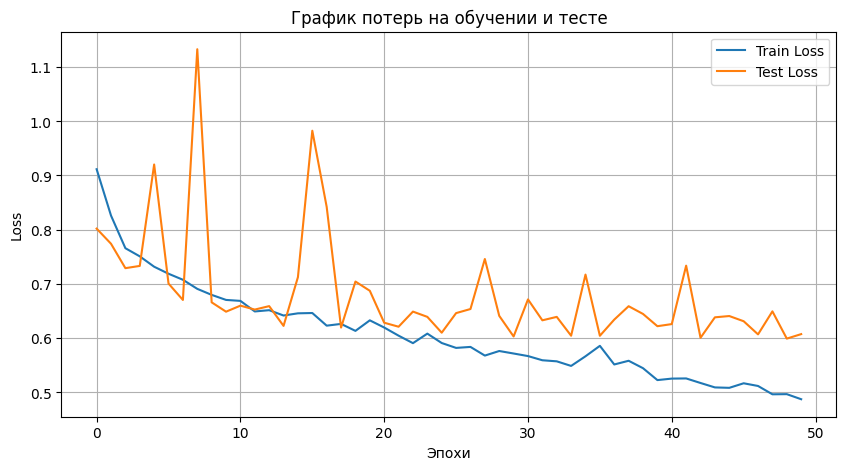

📊 Результаты тестирования:
Точность (Accuracy): 0.7885
Точность (Precision): 0.7762
Полнота (Recall): 0.7885
F1-мера: 0.7600


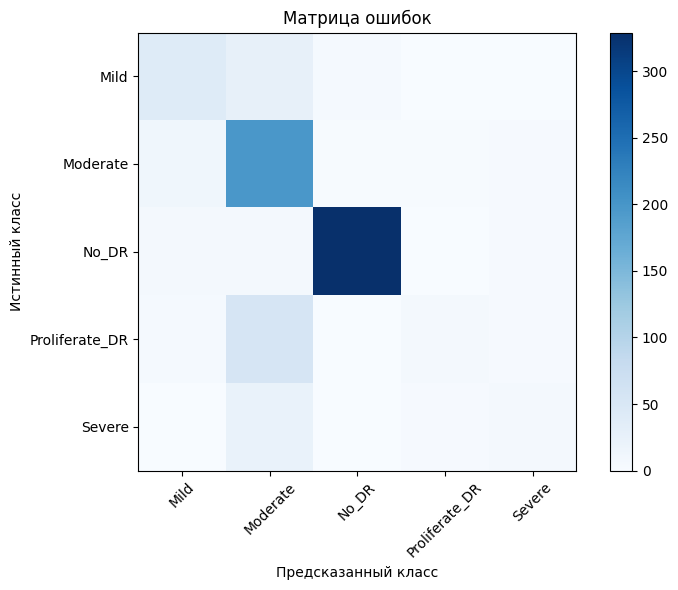


📋 Подробный отчет о классификации:
                precision    recall  f1-score   support

          Mild       0.63      0.56      0.59        72
      Moderate       0.64      0.91      0.75       216
         No_DR       0.98      0.95      0.97       345
Proliferate_DR       0.50      0.09      0.15        68
        Severe       0.40      0.19      0.26        32

      accuracy                           0.79       733
     macro avg       0.63      0.54      0.54       733
  weighted avg       0.78      0.79      0.76       733



In [7]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import numpy as np

# График потерь на обучении и тесте
plt.figure(figsize=(10,5))
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.title('График потерь на обучении и тесте')
plt.xlabel('Эпохи')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

# Оценка точности на тестовом наборе
model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

# Вывод основных метрик
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

print("📊 Результаты тестирования:")
print(f"Точность (Accuracy): {accuracy:.4f}")
print(f"Точность (Precision): {precision:.4f}")
print(f"Полнота (Recall): {recall:.4f}")
print(f"F1-мера: {f1:.4f}")

# Вывод матрицы ошибок
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Матрица ошибок')
plt.colorbar()
tick_marks = np.arange(len(full_dataset.classes))
plt.xticks(tick_marks, full_dataset.classes, rotation=45)
plt.yticks(tick_marks, full_dataset.classes)
plt.ylabel('Истинный класс')
plt.xlabel('Предсказанный класс')
plt.tight_layout()
plt.show()

# Подробный отчет классификации
print("\n📋 Подробный отчет о классификации:")
print(classification_report(y_true, y_pred, target_names=full_dataset.classes))


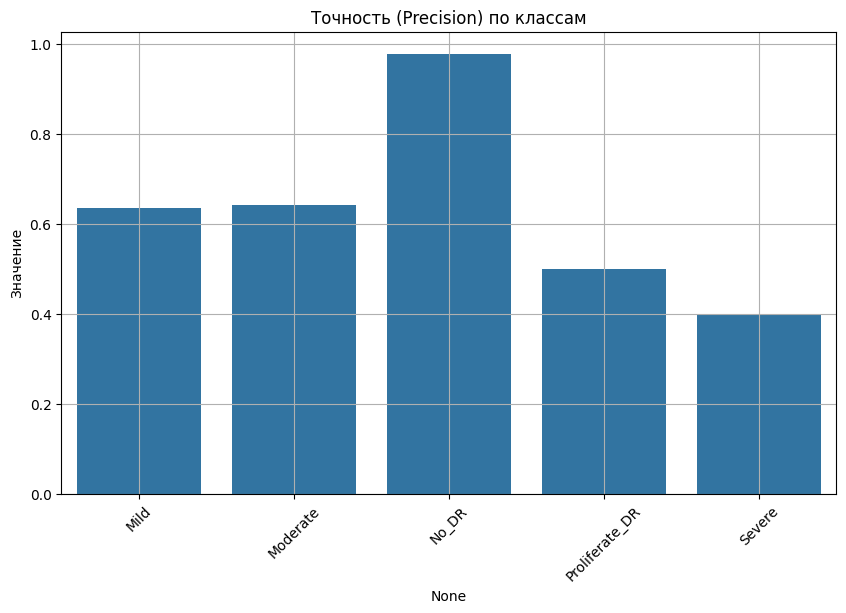

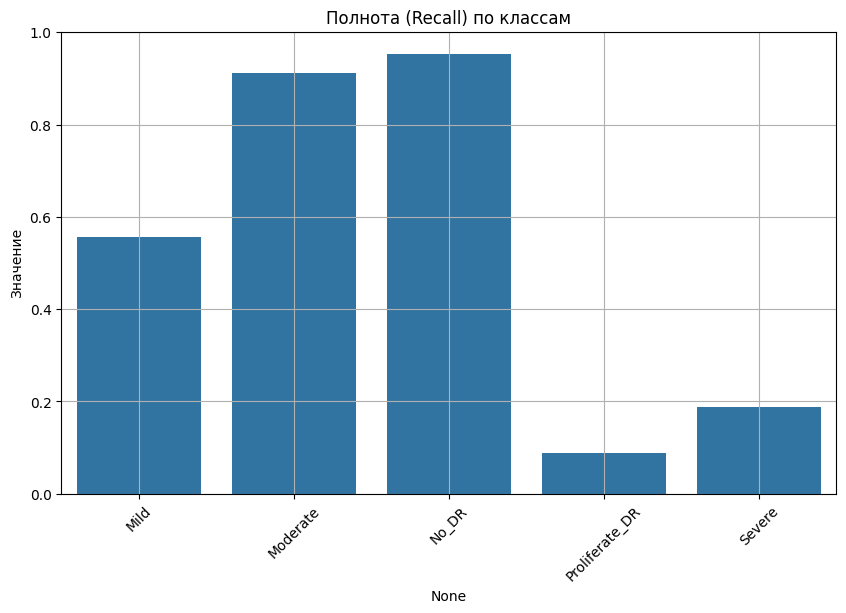

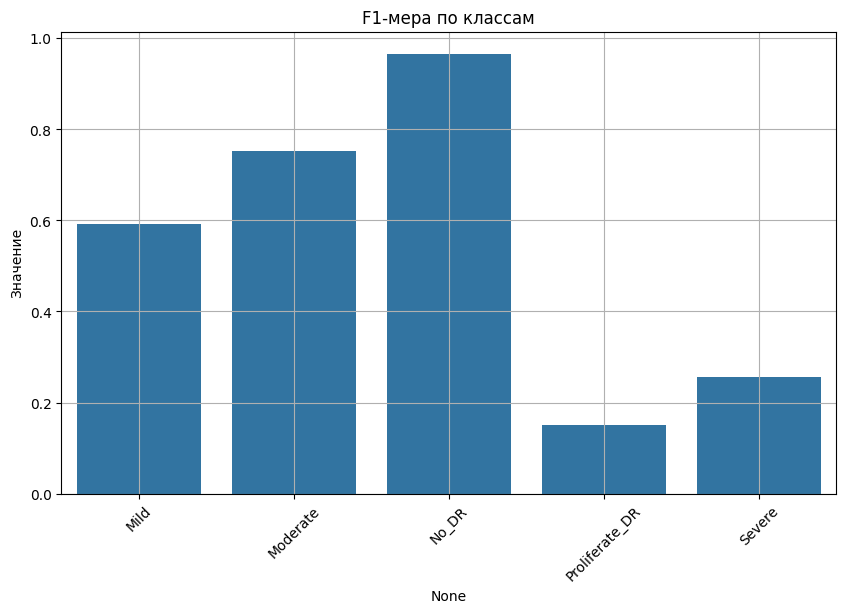

In [8]:
import seaborn as sns
import pandas as pd

# Классы из структуры ImageFolder
class_names = full_dataset.classes  # ['Mild', 'Moderate', 'No_DR', 'Proliferate_DR', 'Severe']

# Получение классификационного отчета
report = classification_report(y_true, y_pred, target_names=class_names, output_dict=True)
report_df = pd.DataFrame(report).transpose()

# Отображение точности, полноты, F1 по классам
plt.figure(figsize=(10,6))
sns.barplot(x=report_df.index[:-3], y=report_df['precision'][:-3])
plt.title('Точность (Precision) по классам')
plt.ylabel('Значение')
plt.xticks(rotation=45)
plt.grid()
plt.show()

plt.figure(figsize=(10,6))
sns.barplot(x=report_df.index[:-3], y=report_df['recall'][:-3])
plt.title('Полнота (Recall) по классам')
plt.ylabel('Значение')
plt.xticks(rotation=45)
plt.grid()
plt.show()

plt.figure(figsize=(10,6))
sns.barplot(x=report_df.index[:-3], y=report_df['f1-score'][:-3])
plt.title('F1-мера по классам')
plt.ylabel('Значение')
plt.xticks(rotation=45)
plt.grid()
plt.show()


In [9]:
from google.colab import files

torch.save(model.state_dict(), "fundus_diagnosis_model.pth")
files.download("fundus_diagnosis_model.pth")

print("✅ Модель успешно скачана на компьютер!")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✅ Модель успешно скачана на компьютер!


In [16]:
from google.colab import files

uploaded = files.upload()


Saving final_model.keras to final_model (1).keras


In [6]:
!pip install gradio

import torch
import torch.nn as nn
from torchvision import transforms
from PIL import Image
import gradio as gr

# Классы диагнозов
class_names = ['Mild', 'Moderate', 'No_DR', 'Proliferate_DR', 'Severe']

# Архитектура модели (та же самая, что при обучении)
class FundusDiagnosisCNN(nn.Module):
    def __init__(self, num_classes=5):
        super(FundusDiagnosisCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding=1), nn.BatchNorm2d(64), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 3, padding=1), nn.BatchNorm2d(128), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(128, 256, 3, padding=1), nn.BatchNorm2d(256), nn.ReLU(), nn.AdaptiveAvgPool2d((7,7))
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256*7*7, 512), nn.ReLU(), nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        return self.classifier(x)

# Устройство
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Загрузка обученной модели
model = FundusDiagnosisCNN()
model.load_state_dict(torch.load("/content/fundus_diagnosis_model.pth", map_location=device))
model = model.to(device)
model.eval()

# Преобразование изображения для подачи в модель
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# Функция для предсказания диагноза
def predict_diagnosis(image):
    image = Image.fromarray(image).convert('RGB')
    image = transform(image).unsqueeze(0).to(device)
    with torch.no_grad():
        output = model(image)
        _, prediction = torch.max(output, 1)
    return f"Диагноз: {class_names[prediction.item()]}"

# Gradio интерфейс
interface = gr.Interface(
    fn=predict_diagnosis,
    inputs=gr.Image(type="numpy", label="Загрузите изображение глазного дна"),
    outputs=gr.Textbox(label="Результат"),
    title="Диагностика заболеваний глазного дна",
    description="Нейросеть для определения стадии диабетической ретинопатии."
)

# Запуск
interface.launch(share=True)


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://86c9e3490ab59070c6.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


ПРИЛОЖЕНИЕ СОВМЕСТНОЕ

In [8]:
# Функция dice_coef (заглушка, которую ты реально использовал при обучении)
import tensorflow.keras.backend as K

def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


In [10]:
def iou(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    union = K.sum(y_true_f) + K.sum(y_pred_f) - intersection
    return (intersection + smooth) / (union + smooth)


In [11]:
segmentation_model = tf.keras.models.load_model(
    segmentation_model_path,
    custom_objects={'dice_coef': dice_coef, 'iou': iou}
)


In [13]:
import tensorflow.keras.backend as K

def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def iou(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    union = K.sum(y_true_f) + K.sum(y_pred_f) - intersection
    return (intersection + smooth) / (union + smooth)

# Теперь загрузка модели
segmentation_model = tf.keras.models.load_model(
    segmentation_model_path,
    custom_objects={'dice_coef': dice_coef, 'iou': iou}
)


In [22]:
# 1. Импорты
import torch
import torch.nn as nn
import tensorflow as tf
import numpy as np
from torchvision import transforms
from PIL import Image
import gradio as gr
import os

# 2. Пути к моделям
segmentation_model_path = "/content/final_model.keras"  # Сегментация
diagnosis_model_path = "/content/fundus_diagnosis_model.pth"  # Диагностика

# 3. Классы диагнозов
class_names = ['Mild', 'Moderate', 'No_DR', 'Proliferate_DR', 'Severe']

# 4. Архитектура модели диагностики
class FundusDiagnosisCNN(nn.Module):
    def __init__(self, num_classes=5):
        super(FundusDiagnosisCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding=1), nn.BatchNorm2d(64), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 3, padding=1), nn.BatchNorm2d(128), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(128, 256, 3, padding=1), nn.BatchNorm2d(256), nn.ReLU(), nn.AdaptiveAvgPool2d((7,7))
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256*7*7, 512), nn.ReLU(), nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        return self.classifier(x)

# 5. Загрузка моделей
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Загрузка модели сегментации (Keras)
segmentation_model = tf.keras.models.load_model(segmentation_model_path)

# Загрузка модели диагностики (PyTorch)
diagnosis_model = FundusDiagnosisCNN()
diagnosis_model.load_state_dict(torch.load(diagnosis_model_path, map_location=device))
diagnosis_model = diagnosis_model.to(device)
diagnosis_model.eval()

# 6. Преобразования для диагностики
transform_input = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# 7. Основная функция
def process_fundus(image):

    # --- 1. Предобработка для сегментации ---
    seg_img = Image.fromarray(image).convert('RGB').resize((224, 224))
    input_array = np.array(seg_img) / 255.0
    input_array = np.expand_dims(input_array, axis=0)

    # --- 2. Сегментация ---
    pred_mask = segmentation_model.predict(input_array)[0, :, :, 0]
    mask_binary = (pred_mask > 0.5).astype(np.uint8) * 255

    # --- 3. Наложение маски ---
    overlay = np.array(seg_img)
    overlay_mask = np.stack([mask_binary]*3, axis=-1)
    overlay_img = np.clip(overlay + overlay_mask//2, 0, 255).astype(np.uint8)

    # --- 4. Предобработка для диагностики ---
    diag_img = Image.fromarray(image).convert('RGB')
    input_diag = transform_input(diag_img).unsqueeze(0).to(device)

    # --- 5. Диагностика ---
    with torch.no_grad():
        output_diag = diagnosis_model(input_diag)
        _, prediction = torch.max(output_diag, 1)
    diagnosis = class_names[prediction.item()]

    # --- 6. Сохранение файлов (если нужно сохранять)
    os.makedirs("/content/results", exist_ok=True)

    overlay_pil = Image.fromarray(overlay_img)
    mask_pil = Image.fromarray(mask_binary)

    overlay_save_path = "/content/results/overlay.png"
    mask_save_path = "/content/results/mask.png"

    overlay_pil.save(overlay_save_path)
    mask_pil.save(mask_save_path)

    return overlay_pil, mask_pil, diagnosis

# 8. Интерфейс Gradio
interface = gr.Interface(
    fn=process_fundus,
    inputs=gr.Image(type="numpy", label="Загрузите изображение глазного дна"),
    outputs=[
        gr.Image(type="pil", label="Изображение с наложением сосудов"),
        gr.Image(type="pil", label="Маска сосудов"),
        gr.Textbox(label="Предварительный диагноз")
    ],
    title="Сегментация сосудов и Диагностика заболеваний глазного дна",
    description="Автоматически выделяет сосуды и ставит предварительный диагноз. Результаты сохраняются в папку /content/results."
)

interface.launch(share=True)


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://8ca6f491cafcd76945.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [23]:
# 1. Импорты
import torch
import torch.nn as nn
import tensorflow as tf
import numpy as np
from torchvision import transforms
from PIL import Image
import gradio as gr
import os
import tensorflow.keras.backend as K
import traceback

# 2. Пути к моделям (ТВОИ)
segmentation_model_path = "/content/final_model.keras"
diagnosis_model_path = "/content/fundus_diagnosis_model.pth"

# 3. Кастомные функции для Keras-модели
def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def iou(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    union = K.sum(y_true_f) + K.sum(y_pred_f) - intersection
    return (intersection + smooth) / (union + smooth)

# 4. Названия классов диагноза
class_names = ['Mild', 'Moderate', 'No_DR', 'Proliferate_DR', 'Severe']

# 5. Архитектура модели диагностики (PyTorch)
class FundusDiagnosisCNN(nn.Module):
    def __init__(self, num_classes=5):
        super(FundusDiagnosisCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding=1), nn.BatchNorm2d(64), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 3, padding=1), nn.BatchNorm2d(128), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(128, 256, 3, padding=1), nn.BatchNorm2d(256), nn.ReLU(), nn.AdaptiveAvgPool2d((7,7))
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256*7*7, 512), nn.ReLU(), nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        return self.classifier(x)

# 6. Устройство
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 7. Загрузка моделей
# Модель сегментации (Keras)
segmentation_model = tf.keras.models.load_model(
    segmentation_model_path,
    custom_objects={'dice_coef': dice_coef, 'iou': iou}
)

# Модель диагностики (PyTorch)
diagnosis_model = FundusDiagnosisCNN()
diagnosis_model.load_state_dict(torch.load(diagnosis_model_path, map_location=device))
diagnosis_model = diagnosis_model.to(device)
diagnosis_model.eval()

# 8. Преобразования для модели диагностики
transform_input = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# 9. Основная функция обработки
def process_fundus(image):
    try:
        # --- 1. Сегментация ---
        seg_img = Image.fromarray(image).convert('RGB').resize((224, 224))
        input_array = np.array(seg_img) / 255.0
        input_array = np.expand_dims(input_array, axis=0)

        pred_mask = segmentation_model.predict(input_array)[0, :, :, 0]
        mask_binary = (pred_mask > 0.5).astype(np.uint8) * 255

        # --- 2. Наложение маски ---
        overlay = np.array(seg_img)
        overlay_mask = np.stack([mask_binary]*3, axis=-1)
        overlay_img = np.clip(overlay + overlay_mask // 2, 0, 255).astype(np.uint8)

        # --- 3. Диагностика ---
        diag_img = Image.fromarray(image).convert('RGB')
        input_diag = transform_input(diag_img).unsqueeze(0).to(device)

        with torch.no_grad():
            output_diag = diagnosis_model(input_diag)
            _, prediction = torch.max(output_diag, 1)
        diagnosis = class_names[prediction.item()]

        # --- 4. Сохранение результатов
        os.makedirs("/content/results", exist_ok=True)
        overlay_pil = Image.fromarray(overlay_img)
        mask_pil = Image.fromarray(mask_binary)

        overlay_pil.save("/content/results/overlay.png")
        mask_pil.save("/content/results/mask.png")

        return overlay_pil, mask_pil, diagnosis

    except Exception as e:
        return None, None, f"❌ Ошибка:\n{traceback.format_exc()}"

# 10. Интерфейс Gradio
interface = gr.Interface(
    fn=process_fundus,
    inputs=gr.Image(type="numpy", label="🧿 Загрузите изображение глазного дна"),
    outputs=[
        gr.Image(type="pil", label="🩺 Наложение маски сосудов"),
        gr.Image(type="pil", label="🧬 Маска сосудов"),
        gr.Textbox(label="📋 Предварительный диагноз")
    ],
    title="Сегментация и диагностика глазного дна",
    description="Загрузите изображение глазного дна, чтобы получить сегментацию сосудов и предварительный диагноз."
)

# 11. Запуск
interface.launch(share=True)


Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/gradio/queueing.py", line 625, in process_events
    response = await route_utils.call_process_api(
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/gradio/route_utils.py", line 322, in call_process_api
    output = await app.get_blocks().process_api(
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/gradio/blocks.py", line 2136, in process_api
    result = await self.call_function(
             ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/gradio/blocks.py", line 1662, in call_function
    prediction = await anyio.to_thread.run_sync(  # type: ignore
                 ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/anyio/to_thread.py", line 56, in run_sync
    return await get_async_backend().run_sync_in_worker_thread(
           ^^^^^

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://eddbe3528c1fae6300.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [2]:
# Установим TensorFlow и Gradio (если не установлены)
!pip install tensorflow gradio


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.0/54.0 MB 18.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.7/322.7 kB 23.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.5/11.5 MB 103.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 5.6 MB/s eta 0:00:00


In [8]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
import torch
import torch.nn as nn
import tensorflow as tf
import numpy as np
import os
import gradio as gr
from torchvision import transforms
from PIL import Image
import tensorflow.keras.backend as K
import traceback

# Пути к моделям
segmentation_model_path = "/content/drive/MyDrive/Colab Notebooks/МОДЕЛИ/final_model.keras"
diagnosis_model_path = "/content/drive/MyDrive/Colab Notebooks/МОДЕЛИ/fundus_diagnosis_model.pth"


In [10]:
# Кастомная метрика Dice
def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

# Кастомная метрика IoU
def iou(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    union = K.sum(y_true_f) + K.sum(y_pred_f) - intersection
    return (intersection + smooth) / (union + smooth)


In [11]:
# Классы диагнозов
class_names = ['Mild', 'Moderate', 'No_DR', 'Proliferate_DR', 'Severe']

# Архитектура модели диагностики
class FundusDiagnosisCNN(nn.Module):
    def __init__(self, num_classes=5):
        super(FundusDiagnosisCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding=1), nn.BatchNorm2d(64), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 3, padding=1), nn.BatchNorm2d(128), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(128, 256, 3, padding=1), nn.BatchNorm2d(256), nn.ReLU(), nn.AdaptiveAvgPool2d((7,7))
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256*7*7, 512), nn.ReLU(), nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        return self.classifier(x)


In [7]:
import os
print(os.path.exists("/content/final_model.keras"))


False


In [12]:
# Устройство для PyTorch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Загрузка модели сегментации
segmentation_model = tf.keras.models.load_model(
    segmentation_model_path,
    custom_objects={'dice_coef': dice_coef, 'iou': iou}
)

# Загрузка модели диагностики
diagnosis_model = FundusDiagnosisCNN()
diagnosis_model.load_state_dict(torch.load(diagnosis_model_path, map_location=device))
diagnosis_model = diagnosis_model.to(device)
diagnosis_model.eval()


FundusDiagnosisCNN(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): AdaptiveAvgPool2d(output_size=(7, 7))
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=12544, out_features=512, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.5, inplace=False)


In [13]:
# Преобразование изображений для подачи в модель диагностики
transform_input = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])


In [14]:
def process_fundus(image):
    try:
        # --- Сегментация ---
        seg_img = Image.fromarray(image).convert('RGB').resize((224, 224))
        input_array = np.array(seg_img) / 255.0
        input_array = np.expand_dims(input_array, axis=0)

        pred_mask = segmentation_model.predict(input_array, verbose=0)[0, :, :, 0]
        mask_binary = (pred_mask > 0.5).astype(np.uint8) * 255

        # --- Наложение маски на изображение ---
        overlay = np.array(seg_img)
        overlay_mask = np.stack([mask_binary]*3, axis=-1)
        overlay_img = np.clip(overlay + overlay_mask//2, 0, 255).astype(np.uint8)

        # --- Диагностика ---
        diag_img = Image.fromarray(image).convert('RGB')
        input_diag = transform_input(diag_img).unsqueeze(0).to(device)

        with torch.no_grad():
            output_diag = diagnosis_model(input_diag)
            _, prediction = torch.max(output_diag, 1)
        diagnosis = class_names[prediction.item()]

        # --- Сохранение результатов
        os.makedirs("/content/results", exist_ok=True)
        overlay_pil = Image.fromarray(overlay_img)
        mask_pil = Image.fromarray(mask_binary)

        overlay_pil.save("/content/results/overlay.png")
        mask_pil.save("/content/results/mask.png")

        return overlay_pil, mask_pil, diagnosis

    except Exception as e:
        return None, None, f"❌ Ошибка:\n{traceback.format_exc()}"


In [15]:
interface = gr.Interface(
    fn=process_fundus,
    inputs=gr.Image(type="numpy", label="🧿 Загрузите изображение глазного дна"),
    outputs=[
        gr.Image(type="pil", label="🩺 Наложение сосудистой маски"),
        gr.Image(type="pil", label="🧬 Маска сосудов"),
        gr.Textbox(label="📋 Предварительный диагноз")
    ],
    title="Сегментация сосудов и диагностика глазного дна",
    description="ИИ для выделения сосудов на изображении глазного дна и постановки диагноза."
)

# Запуск
interface.launch(share=True)


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://5b3f102780076584d1.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [16]:
def process_fundus(image):
    try:
        # --- Сегментация (модель ждёт 256×256) ---
        seg_img = Image.fromarray(image).convert('RGB').resize((256, 256))
        input_array = np.array(seg_img) / 255.0
        input_array = np.expand_dims(input_array, axis=0)

        pred_mask = segmentation_model.predict(input_array, verbose=0)[0, :, :, 0]
        mask_binary = (pred_mask > 0.5).astype(np.uint8) * 255

        # --- Наложение маски ---
        overlay = np.array(seg_img)
        overlay_mask = np.stack([mask_binary]*3, axis=-1)
        overlay_img = np.clip(overlay + overlay_mask // 2, 0, 255).astype(np.uint8)

        # --- Диагностика (модель ждёт 224×224) ---
        diag_img = Image.fromarray(image).convert('RGB').resize((224, 224))
        input_diag = transform_input(diag_img).unsqueeze(0).to(device)

        with torch.no_grad():
            output_diag = diagnosis_model(input_diag)
            _, prediction = torch.max(output_diag, 1)
        diagnosis = class_names[prediction.item()]

        # --- Сохранение результатов
        os.makedirs("/content/results", exist_ok=True)
        Image.fromarray(overlay_img).save("/content/results/overlay.png")
        Image.fromarray(mask_binary).save("/content/results/mask.png")

        return Image.fromarray(overlay_img), Image.fromarray(mask_binary), diagnosis

    except Exception as e:
        return None, None, f"❌ Ошибка:\n{traceback.format_exc()}"


In [17]:
interface = gr.Interface(
    fn=process_fundus,
    inputs=gr.Image(type="numpy", label="🧿 Загрузите изображение глазного дна"),
    outputs=[
        gr.Image(type="pil", label="🩺 Наложение сосудистой маски"),
        gr.Image(type="pil", label="🧬 Маска сосудов"),
        gr.Textbox(label="📋 Предварительный диагноз")
    ],
    title="Сегментация и диагностика глазного дна",
    description="ИИ анализирует изображение, выделяет сосуды и ставит диагноз. Маска и наложение сохраняются в /content/results."
)

interface.launch(share=True)


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://e148beeff5c5700d71.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
